# Problem Statement

I have written my own data retrieval python program that retrieves data from Land Transport Authority (LTA) DataMall Bus Arrival API (https://datamall.lta.gov.sg/). The program collects data from the API every minute for a specific bus route and appends the results into a CSV file.

Given this dataset, can we capture the seasonality and patterns that is present and predict the travel duration between two stops accurately using Machine Learning (ML) algorithms?

In [1]:
import pandas as pd

csv_file_path = '../data-retriever/data/903-16102021.csv'

#NEW API SCHEMA 2021
#Origin, Destination, ETA, Lat, Long, Visit Number, Load, Feature, Type, Current Stop, Next Stop, Service, Current Time
new_col =  ['origin', 'dest', 'eta', 'lat', 'long', 'visit_num', 'load', 'feature', 'type', 'current_stop', \
            'next_stop', 'service', 'current_time', 'eta2']

df = pd.read_csv(csv_file_path, index_col=False, names = new_col)


# Let's take a brief look at our dataset! 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        34994 non-null  float64
 1   dest          34994 non-null  float64
 2   eta           34994 non-null  object 
 3   lat           34994 non-null  float64
 4   long          34994 non-null  float64
 5   visit_num     34994 non-null  float64
 6   load          34994 non-null  object 
 7   feature       34994 non-null  object 
 8   type          34994 non-null  object 
 9   current_stop  35260 non-null  int64  
 10  next_stop     33665 non-null  float64
 11  service       35260 non-null  int64  
 12  current_time  35260 non-null  object 
 13  eta2          34130 non-null  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 3.8+ MB


# Handling NaN values in our dataset
Oh? We have some NaN values in our next_stop column, let's dig deep to find out why!

In [3]:
df.loc[df['next_stop'].isnull()]

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2
21,46009.0,46009.0,2021-10-16T17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,NaN,903,2021-10-16 17:29:21.462561+08:00,2021-10-16T17:42:00+08:00
43,46009.0,46009.0,2021-10-16T17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,NaN,903,2021-10-16 17:30:22.628345+08:00,2021-10-16T17:42:00+08:00
65,46009.0,46009.0,2021-10-16T17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-16 17:31:23.589244+08:00,2021-10-16T17:48:00+08:00
87,46009.0,46009.0,2021-10-16T17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-16 17:32:24.644859+08:00,2021-10-16T17:48:00+08:00
109,46009.0,46009.0,2021-10-16T17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-16 17:33:25.598640+08:00,2021-10-16T17:48:00+08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35171,46009.0,46009.0,2021-10-17T12:57:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-17 12:53:14.582111+08:00,2021-10-17T13:03:00+08:00
35193,46009.0,46009.0,2021-10-17T12:57:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-17 12:53:42.081754+08:00,2021-10-17T13:03:00+08:00
35215,46009.0,46009.0,2021-10-17T12:57:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-17 12:54:04.093132+08:00,2021-10-17T13:03:00+08:00
35237,46009.0,46009.0,2021-10-17T12:57:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,NaN,903,2021-10-17 12:54:15.202933+08:00,2021-10-17T13:03:00+08:00


After investigating further by taking a look at our route file, it turns out that this bus service is a loop service (starting and ending on the same stop). Hence, the API does not distinguish between the arrival time at the starting and ending stop, returning only the ETA of the starting stop. 

In short, it is safe to drop these rows!

In [4]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

# Let's do some calculations and create new columns!

## Extracting information from datetime fields

We can extract some data from the datetime fields which can be used for analysis or feature engineering.

In [5]:
#Convert to eta column into a datetime field
df['eta'] = pd.to_datetime(df['eta'])
df['eta2'] = pd.to_datetime(df['eta2'])
df['current_time'] = pd.to_datetime(df['current_time'])

#Extract hour from current_time field
df['hour'] = df['current_time'].dt.hour

#Extract day of week from current_time field
df['day'] = df['current_time'].dt.dayofweek

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46009,46271.0,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5
1,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46271,46301.0,903,2021-10-16 17:29:20.773900+08:00,2021-10-16 17:43:09+08:00,17,5
2,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46301,46311.0,903,2021-10-16 17:29:20.803550+08:00,2021-10-16 17:44:27+08:00,17,5
3,46009.0,46009.0,2021-10-16 17:28:23+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46311,46249.0,903,2021-10-16 17:29:20.829795+08:00,2021-10-16 17:33:20+08:00,17,5
4,46009.0,46009.0,2021-10-16 17:29:21+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46249,46179.0,903,2021-10-16 17:29:20.864316+08:00,2021-10-16 17:34:23+08:00,17,5


In [6]:
#Convert numerical data columns to Integer
df['current_stop'] = df['current_stop'].astype(int)
df['next_stop'] = df['next_stop'].astype(int)

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5
1,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46271,46301,903,2021-10-16 17:29:20.773900+08:00,2021-10-16 17:43:09+08:00,17,5
2,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46301,46311,903,2021-10-16 17:29:20.803550+08:00,2021-10-16 17:44:27+08:00,17,5
3,46009.0,46009.0,2021-10-16 17:28:23+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46311,46249,903,2021-10-16 17:29:20.829795+08:00,2021-10-16 17:33:20+08:00,17,5
4,46009.0,46009.0,2021-10-16 17:29:21+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46249,46179,903,2021-10-16 17:29:20.864316+08:00,2021-10-16 17:34:23+08:00,17,5


# Calculating travel duration between two stops

Since we have the estimated time of arrival (ETA) for bus stops A -> B, B -> C, C -> ... that was retrieved from the API, we can calculate the travel duration that it takes for the bus to travel from the current stop to the next stop.


In [7]:
#Number of bus stops
bus_stops = df['current_stop'].unique()
print(len(bus_stops))
bus_stops

21


array([46009, 46271, 46301, 46311, 46249, 46179, 46169, 46159, 46149,
       46119, 46069, 46088, 46111, 46141, 46151, 46161, 46171, 46241,
       46319, 46309, 46279])

## Let's take a look into the first 21 rows of the dataset!

The intuition of the calculation is to minus the ETA of row number n+1 from the ETA of row number n in order to produce the travel duration between two stops

In [8]:
df.head(21)

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5
1,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46271,46301,903,2021-10-16 17:29:20.773900+08:00,2021-10-16 17:43:09+08:00,17,5
2,46009.0,46009.0,2021-10-16 17:32:41+08:00,0.000000,0.000000,1.0,SEA,WAB,SD,46301,46311,903,2021-10-16 17:29:20.803550+08:00,2021-10-16 17:44:27+08:00,17,5
3,46009.0,46009.0,2021-10-16 17:28:23+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46311,46249,903,2021-10-16 17:29:20.829795+08:00,2021-10-16 17:33:20+08:00,17,5
4,46009.0,46009.0,2021-10-16 17:29:21+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46249,46179,903,2021-10-16 17:29:20.864316+08:00,2021-10-16 17:34:23+08:00,17,5
5,46009.0,46009.0,2021-10-16 17:30:18+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46179,46169,903,2021-10-16 17:29:20.894922+08:00,2021-10-16 17:35:22+08:00,17,5
6,46009.0,46009.0,2021-10-16 17:32:14+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46169,46159,903,2021-10-16 17:29:20.920416+08:00,2021-10-16 17:37:02+08:00,17,5
7,46009.0,46009.0,2021-10-16 17:32:45+08:00,1.442643,103.780624,1.0,SEA,WAB,DD,46159,46149,903,2021-10-16 17:29:20.955717+08:00,2021-10-16 17:37:31+08:00,17,5
8,46009.0,46009.0,2021-10-16 17:29:38+08:00,1.445700,103.773371,1.0,SEA,WAB,DD,46149,46119,903,2021-10-16 17:29:20.984121+08:00,2021-10-16 17:34:33+08:00,17,5
9,46009.0,46009.0,2021-10-16 17:32:04+08:00,1.445700,103.773371,1.0,SEA,WAB,DD,46119,46069,903,2021-10-16 17:29:21.033000+08:00,2021-10-16 17:36:59+08:00,17,5


In [9]:
def calculate(stop_a, stop_b):
    stop_a['end'] = stop_b['eta']
    stop_a['stop_b_eta2'] = stop_b['eta2']
    #Get duration start and end times from stop_a and stop_b's arrival time
    stop_a['duration'] = stop_a['end'] - stop_a['eta']
    
    return stop_a
    
    
def get_stops(df, bus_stops):
    new_df = pd.DataFrame()
    
    for i, current_stop in enumerate(bus_stops):
        if i == len(bus_stops) - 1:
            break
            
        #print(current_stop)
        stop_a = df.loc[df['current_stop'] == current_stop].copy()
        stop_b = df.loc[df['current_stop'] == bus_stops[i + 1]].copy()
        stop_a.reset_index(drop=True, inplace=True)
        stop_b.reset_index(drop=True, inplace=True)
        #print(len(stop_a))
        #print(len(stop_b))
        result = calculate(stop_a, stop_b)
        #print(len(result))
        
        new_df = new_df.append(result)
        
    return new_df

df = get_stops(df, bus_stops)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31034 entries, 0 to 1547
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   origin        31034 non-null  float64                              
 1   dest          31034 non-null  float64                              
 2   eta           31034 non-null  datetime64[ns, pytz.FixedOffset(480)]
 3   lat           31034 non-null  float64                              
 4   long          31034 non-null  float64                              
 5   visit_num     31034 non-null  float64                              
 6   load          31034 non-null  object                               
 7   feature       31034 non-null  object                               
 8   type          31034 non-null  object                               
 9   current_stop  31034 non-null  int64                                
 10  next_stop  

## Do you notice anything weird happening?

Negative values in the duration column!

In [10]:
df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day,end,stop_b_eta2,duration
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:32:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:02:41
1,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:30:21.699486+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:33:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:03:41
2,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:31:22.793028+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:34:41+08:00,2021-10-16 17:43:09+08:00,-1 days +23:52:41
3,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:32:23.847334+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:57+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:57
4,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:33:24.870336+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:56+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:56


In [11]:
#Calculate duration column and get results in seconds
df['duration_seconds'] = df['duration'].dt.total_seconds()

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,hour,day,end,stop_b_eta2,duration,duration_seconds
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:32:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:02:41,161.0
1,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,46271,903,2021-10-16 17:30:21.699486+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:33:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:03:41,221.0
2,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:31:22.793028+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:34:41+08:00,2021-10-16 17:43:09+08:00,-1 days +23:52:41,-439.0
3,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:32:23.847334+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:57+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:57,-543.0
4,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,46271,903,2021-10-16 17:33:24.870336+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:56+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:56,-544.0


In [12]:
def calculate_duration2(row):
    if row.duration_seconds < 0:
        return row.stop_b_eta2 - row.eta
    else:
        return row.end - row.eta
        
df['duration2'] = df.apply(lambda row: calculate_duration2(row), axis=1)

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,...,service,current_time,eta2,hour,day,end,stop_b_eta2,duration,duration_seconds,duration2
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,903,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:32:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:02:41,161.0,0 days 00:02:41
1,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,903,2021-10-16 17:30:21.699486+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:33:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:03:41,221.0,0 days 00:03:41
2,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,903,2021-10-16 17:31:22.793028+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:34:41+08:00,2021-10-16 17:43:09+08:00,-1 days +23:52:41,-439.0,0 days 00:01:09
3,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,903,2021-10-16 17:32:23.847334+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:57+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:57,-543.0,0 days 00:01:09
4,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,903,2021-10-16 17:33:24.870336+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:56+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:56,-544.0,0 days 00:01:09


In [13]:
df['duration_seconds2'] = df['duration2'].dt.total_seconds()

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,...,current_time,eta2,hour,day,end,stop_b_eta2,duration,duration_seconds,duration2,duration_seconds2
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:32:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:02:41,161.0,0 days 00:02:41,161.0
1,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,2021-10-16 17:30:21.699486+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:33:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:03:41,221.0,0 days 00:03:41,221.0
2,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:31:22.793028+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:34:41+08:00,2021-10-16 17:43:09+08:00,-1 days +23:52:41,-439.0,0 days 00:01:09,69.0
3,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:32:23.847334+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:57+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:57,-543.0,0 days 00:01:09,69.0
4,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:33:24.870336+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:56+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:56,-544.0,0 days 00:01:09,69.0


In [14]:
df.loc[df['duration_seconds2'] < 0]

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,...,current_time,eta2,hour,day,end,stop_b_eta2,duration,duration_seconds,duration2,duration_seconds2
504,46009.0,46009.0,2021-10-17 05:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,DD,46009,...,2021-10-17 04:54:36.577250+08:00,2021-10-17 05:38:00+08:00,4,6,2021-10-17 00:52:41+08:00,2021-10-17 01:01:09+08:00,-1 days +19:22:41,-16639.0,-1 days +19:31:09,-16131.0
505,46009.0,46009.0,2021-10-17 05:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,DD,46009,...,2021-10-17 04:55:03.257069+08:00,2021-10-17 05:38:00+08:00,4,6,2021-10-17 00:51:26+08:00,2021-10-17 01:01:09+08:00,-1 days +19:21:26,-16714.0,-1 days +19:31:09,-16131.0
506,46009.0,46009.0,2021-10-17 05:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,DD,46009,...,2021-10-17 04:55:37.054926+08:00,2021-10-17 05:38:00+08:00,4,6,2021-10-17 00:51:26+08:00,2021-10-17 01:01:09+08:00,-1 days +19:21:26,-16714.0,-1 days +19:31:09,-16131.0
507,46009.0,46009.0,2021-10-17 05:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,DD,46009,...,2021-10-17 04:56:03.721475+08:00,2021-10-17 05:38:00+08:00,4,6,2021-10-17 00:51:27+08:00,2021-10-17 01:01:09+08:00,-1 days +19:21:27,-16713.0,-1 days +19:31:09,-16131.0
508,46009.0,46009.0,2021-10-17 05:30:00+08:00,0.000000,0.000000,1.0,SEA,WAB,DD,46009,...,2021-10-17 04:56:37.596395+08:00,2021-10-17 05:38:00+08:00,4,6,2021-10-17 00:51:27+08:00,2021-10-17 01:01:09+08:00,-1 days +19:21:27,-16713.0,-1 days +19:31:09,-16131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,46009.0,46009.0,2021-10-17 11:09:04+08:00,1.441248,103.771046,1.0,SEA,WAB,DD,46309,...,2021-10-17 11:01:08.091971+08:00,2021-10-17 11:12:13+08:00,11,6,2021-10-17 10:57:33+08:00,2021-10-17 11:00:54+08:00,-1 days +23:48:29,-691.0,-1 days +23:51:50,-490.0
1261,46009.0,46009.0,2021-10-17 11:19:26+08:00,1.445316,103.772591,1.0,SEA,WAB,DD,46309,...,2021-10-17 11:14:16.224874+08:00,2021-10-17 11:25:29+08:00,11,6,2021-10-17 11:12:10+08:00,2021-10-17 11:14:27+08:00,-1 days +23:52:44,-436.0,-1 days +23:55:01,-299.0
1262,46009.0,46009.0,2021-10-17 11:19:26+08:00,1.445316,103.772591,1.0,SEA,WAB,DD,46309,...,2021-10-17 11:14:44.111536+08:00,2021-10-17 11:25:29+08:00,11,6,2021-10-17 11:12:30+08:00,2021-10-17 11:14:16+08:00,-1 days +23:53:04,-416.0,-1 days +23:54:50,-310.0
1263,46009.0,46009.0,2021-10-17 11:19:26+08:00,1.445316,103.772591,1.0,SEA,WAB,DD,46309,...,2021-10-17 11:15:16.853295+08:00,2021-10-17 11:25:29+08:00,11,6,2021-10-17 11:12:30+08:00,2021-10-17 11:14:16+08:00,-1 days +23:53:04,-416.0,-1 days +23:54:50,-310.0


## Why is this happening?

In [15]:
df = df.loc[df['duration_seconds2'] > 0]
df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,...,current_time,eta2,hour,day,end,stop_b_eta2,duration,duration_seconds,duration2,duration_seconds2
0,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,2021-10-16 17:29:20.736717+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:32:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:02:41,161.0,0 days 00:02:41,161.0
1,46009.0,46009.0,2021-10-16 17:30:00+08:00,0.0,0.0,1.0,SEA,WAB,SD,46009,...,2021-10-16 17:30:21.699486+08:00,2021-10-16 17:42:00+08:00,17,5,2021-10-16 17:33:41+08:00,2021-10-16 17:43:09+08:00,0 days 00:03:41,221.0,0 days 00:03:41,221.0
2,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:31:22.793028+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:34:41+08:00,2021-10-16 17:43:09+08:00,-1 days +23:52:41,-439.0,0 days 00:01:09,69.0
3,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:32:23.847334+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:57+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:57,-543.0,0 days 00:01:09,69.0
4,46009.0,46009.0,2021-10-16 17:42:00+08:00,0.0,0.0,1.0,SEA,WAB,DD,46009,...,2021-10-16 17:33:24.870336+08:00,2021-10-16 17:48:00+08:00,17,5,2021-10-16 17:32:56+08:00,2021-10-16 17:43:09+08:00,-1 days +23:50:56,-544.0,0 days 00:01:09,69.0


# Unique bus stops

In [16]:
bus_stops = df['current_stop'].unique()
bus_stops

array([46009, 46271, 46301, 46311, 46249, 46179, 46169, 46159, 46149,
       46119, 46069, 46088, 46111, 46141, 46151, 46161, 46171, 46241,
       46319, 46309])

<AxesSubplot:xlabel='current_time', ylabel='duration_seconds2'>

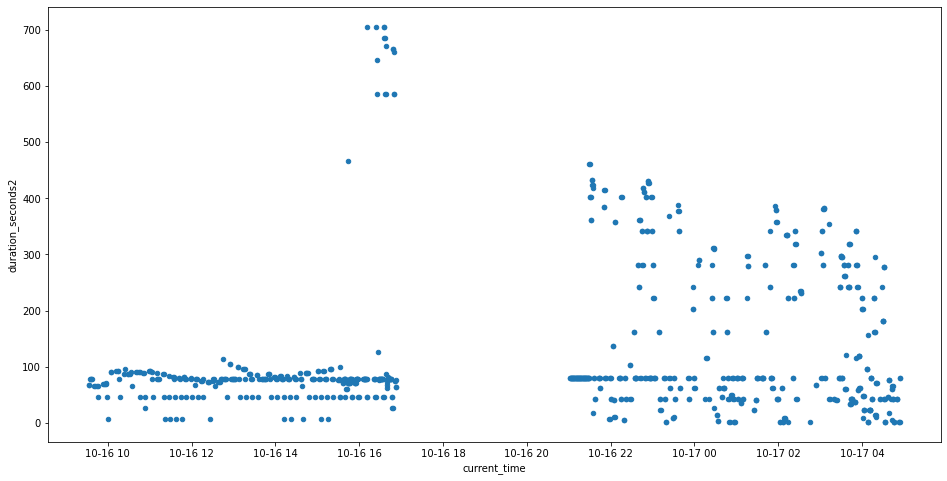

In [17]:
target_stop = df.loc[df['current_stop'] == 46271]

target_stop.plot.scatter(x='current_time', y='duration_seconds2',figsize=(16,8))

## Scatter plot of Hour of the day against Travel Duration (seconds)

<AxesSubplot:xlabel='hour', ylabel='duration_seconds2'>

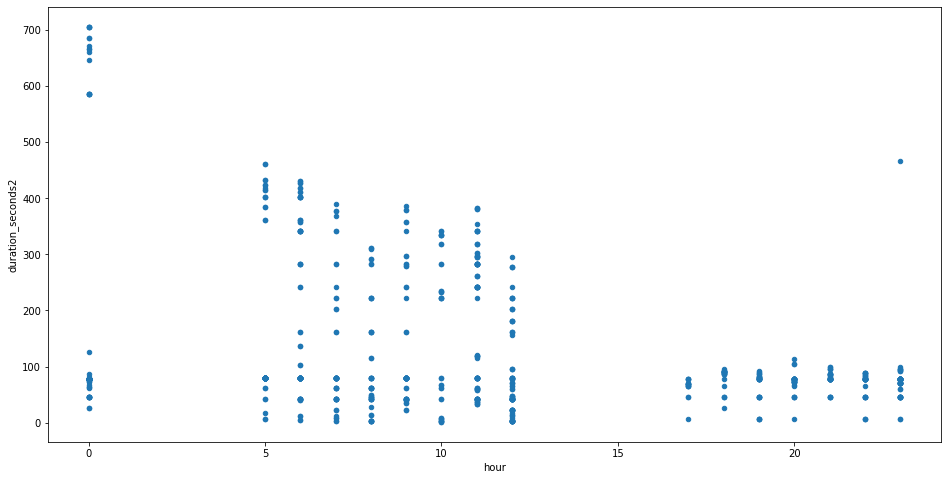

In [18]:
target_stop.plot.scatter(x='hour', y='duration_seconds2',figsize=(16,8))

## Scatter plot of Day of week (e.g. Mon, Tues, Wed) against Travel Duration (seconds)

<AxesSubplot:xlabel='day', ylabel='duration_seconds2'>

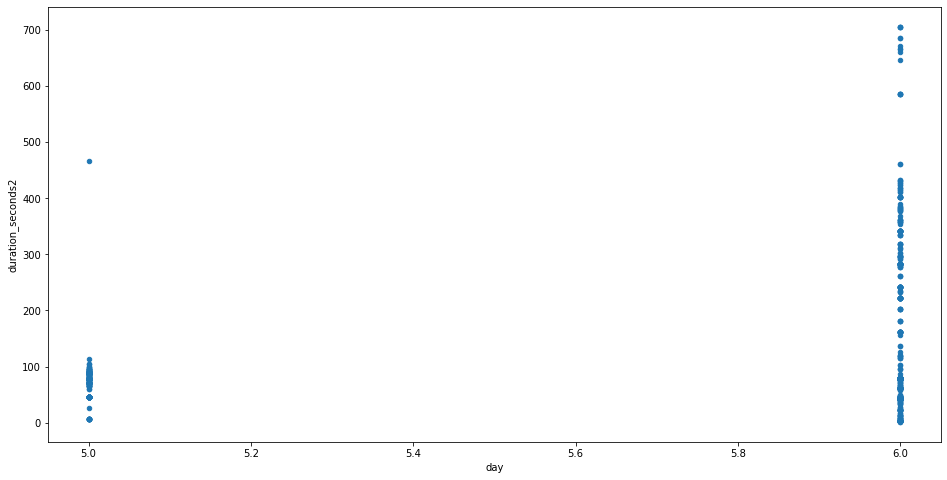

In [19]:
target_stop.plot.scatter(x='day', y='duration_seconds2',figsize=(16,8))

In [20]:
df['load'].unique()

array(['SEA', 'SDA'], dtype=object)

## Plot of Bus Load (Seating) vs Travel Duration

<AxesSubplot:>

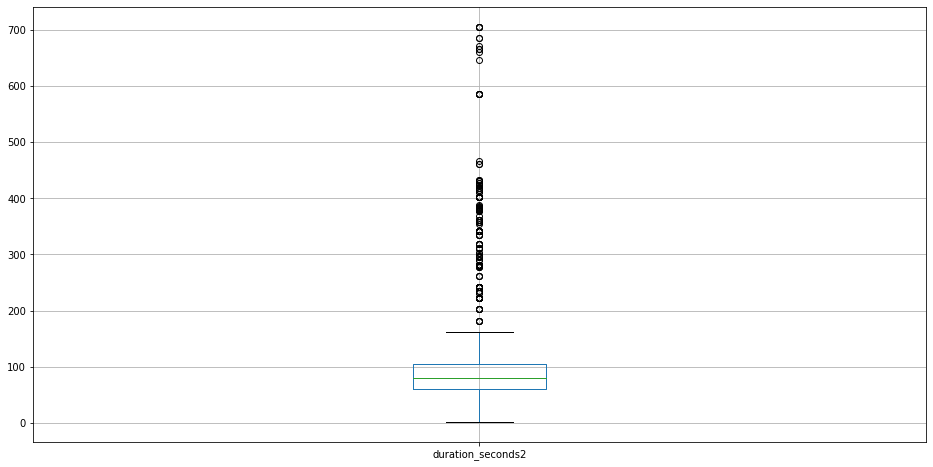

In [21]:
target_stop.loc[target_stop['load'] == 'SEA'].boxplot(column='duration_seconds2',figsize=(16,8))

## Plot of Bus Load (Standing) vs Travel Duration

<AxesSubplot:>

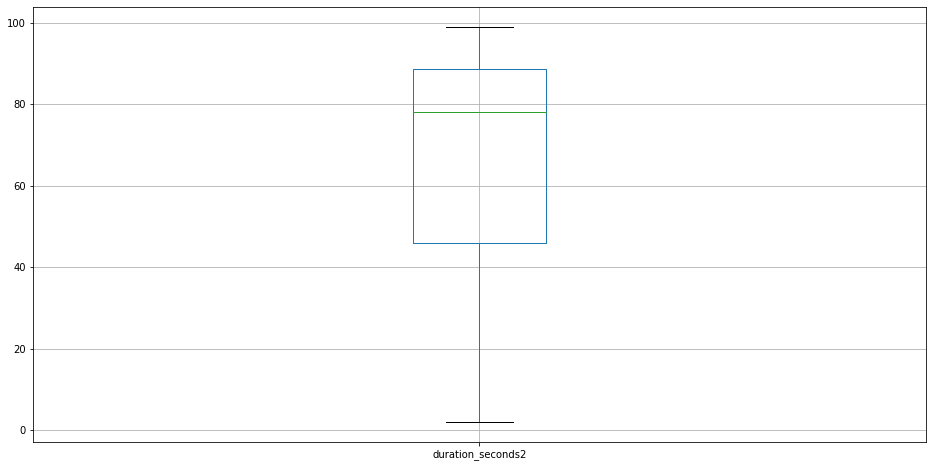

In [22]:
target_stop.loc[target_stop['load'] == 'SDA'].boxplot(column='duration_seconds2',figsize=(16,8))

In [23]:
df['type'].unique()

array(['SD', 'DD'], dtype=object)

## Plot of Bus Type (Single-deck) vs Travel Duration

<AxesSubplot:>

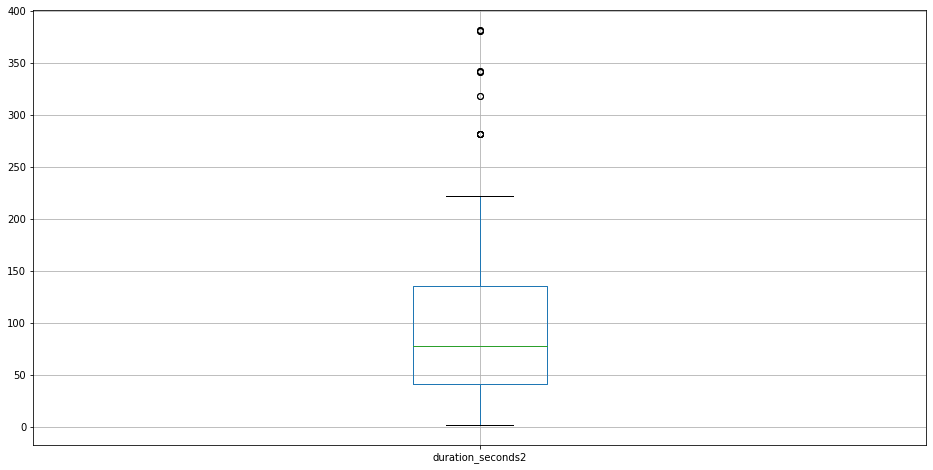

In [24]:
target_stop.loc[target_stop['type'] == 'SD'].boxplot(column='duration_seconds2',figsize=(16,8))

## Plot of Bus Type (Double-deck) vs Travel Duration

Does the type of bus affects the travel duration?

<AxesSubplot:>

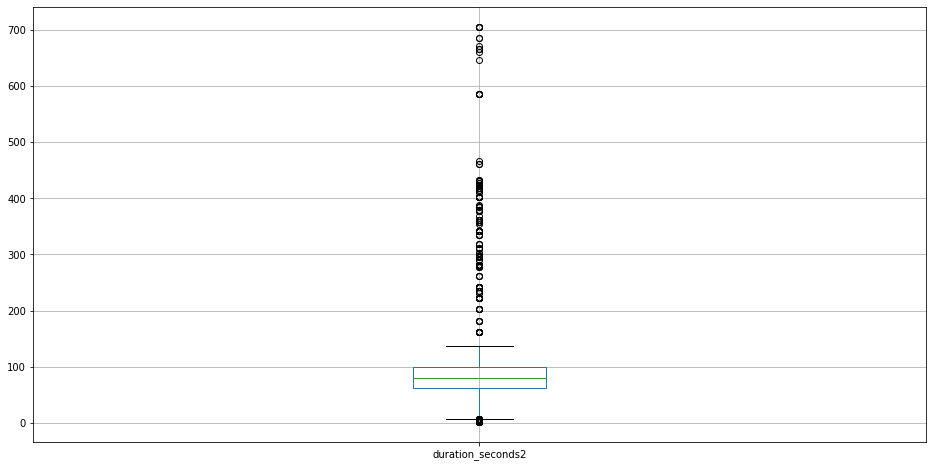

In [25]:
target_stop.loc[target_stop['type'] == 'DD'].boxplot(column='duration_seconds2',figsize=(16,8))

# Summary

## Findings
